# Demand Forecasting using Time Series

## What is Time Series?

Time series is a series of data points indexed (or listed or graphed) in time order. Therefore, the data is organized by relatively deterministic timestamps, and may, compared to random sample data, contain additional information that we can extract.

## Necessary Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import time
import seaborn as sns
import pandas as pd
import matplotlib as plt
import numpy as np
import joblib
import statsmodels.api as sm

from fbprophet import Prophet
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold
from scipy import stats, optimize, interpolate
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

In [3]:
df_raw = pd.read_csv('Stores_train.csv', low_memory=False, parse_dates=['date'], index_col=['date'])

In [4]:
df_raw.head()

,dept,item,sales
date,,,
2015-01-01,1,1,13
2015-01-02,1,1,11
2015-01-03,1,1,14
2015-01-04,1,1,13
2015-01-05,1,1,10


In [5]:
print("Train shape is {}".format(df_raw.shape))

Train shape is (912500, 3)


<AxesSubplot:xlabel='date'>

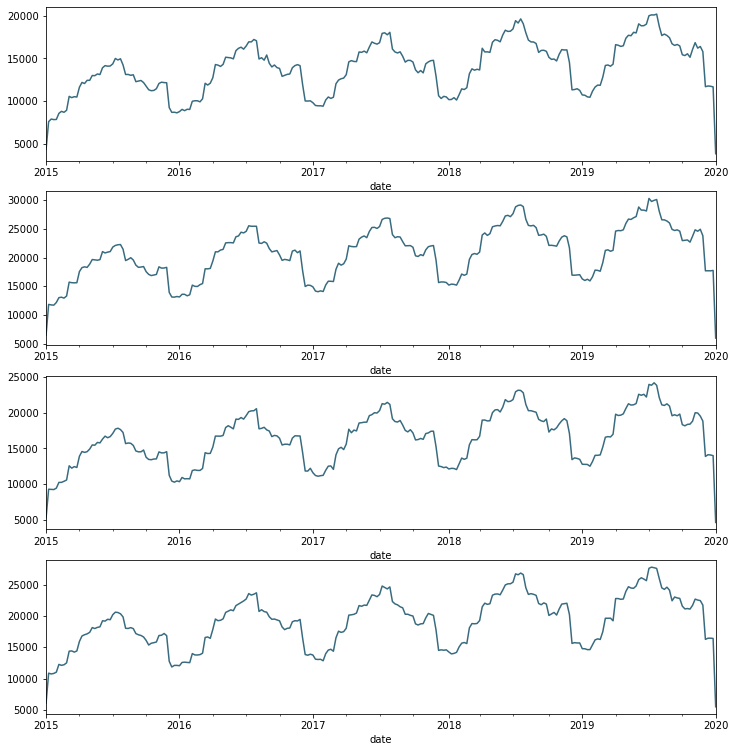

In [6]:
#### Seasonality Check
# preparation: input should be float type
df_raw['sales'] = df_raw['sales'] * 1.0

# store types
sales_a = df_raw[df_raw.dept == 5]['sales'].sort_index(ascending = True)
sales_b = df_raw[df_raw.dept == 3]['sales'].sort_index(ascending = True) # solve the reverse order
sales_c = df_raw[df_raw.dept == 1]['sales'].sort_index(ascending = True)
sales_d = df_raw[df_raw.dept == 4]['sales'].sort_index(ascending = True)

f, (ax1, ax2, ax3, ax4) = plt.pyplot.subplots(4, figsize = (12, 13))
c = '#386B7F'

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

#All Stores have same trend... Weird Seems like the dataset is A Synthetic One..;

C:\Users\reddy\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead

C:\Users\reddy\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead

C:\Users\reddy\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead

C:\Users\reddy\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



<AxesSubplot:xlabel='date'>

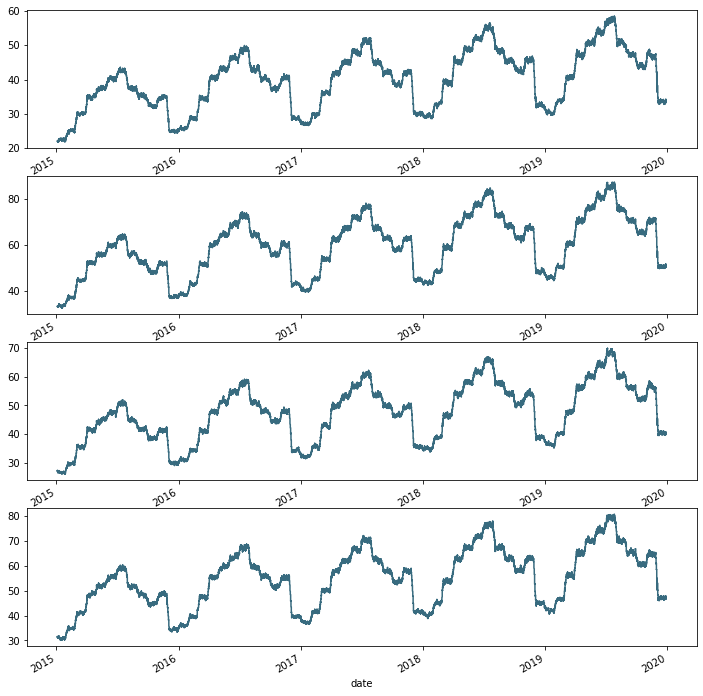

In [7]:
f, (ax1, ax2, ax3, ax4) = plt.pyplot.subplots(4, figsize = (12, 13))

# Yearly
decomposition_a = sm.tsa.seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = sm.tsa.seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = sm.tsa.seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = sm.tsa.seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4)

In [8]:
# Temporary DataFrame
date_sales = df_raw.drop(['dept','item'], axis=1).copy() 

In [9]:
y = date_sales['sales'].resample('MS').mean() 
y['2019':] #sneak peak

date
2019-01-01    39.826194
2019-02-01    44.383500
2019-03-01    53.075290
2019-04-01    62.590800
2019-05-01    65.850710
2019-06-01    70.974933
2019-07-01    75.573742
2019-08-01    66.219548
2019-09-01    62.350867
2019-10-01    57.494194
2019-11-01    61.922467
2019-12-01    44.849677
Freq: MS, Name: sales, dtype: float64

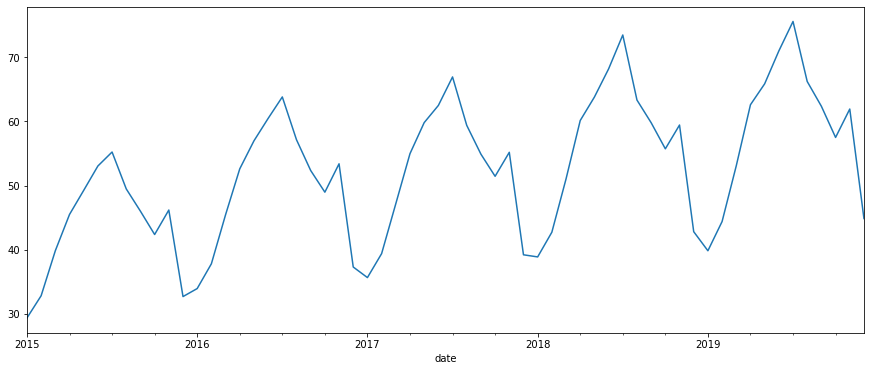

In [10]:
y.plot(figsize=(15, 6),);
#The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the middle(festive season maybe) of the year
# and again low at the end of the year...
#There is always an upward trend within any single year with a couple of low months in the mid of the year...

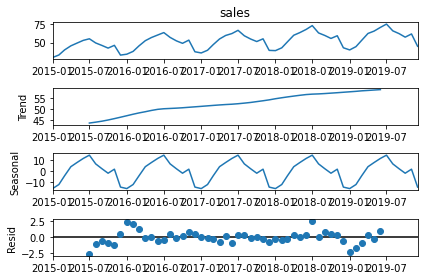

In [11]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: 
#trend, seasonality, and noise.
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot();
#The plot clearly shows that the sales is unstable, along with its obvious seasonality.;

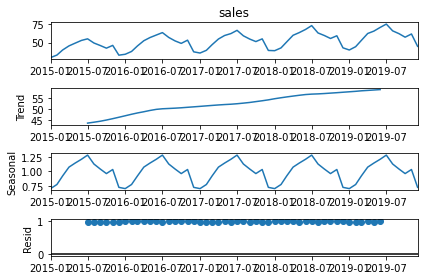

In [12]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: 
#trend, seasonality, and noise.
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
decomposition.plot();
#The plot above clearly shows that the sales is unstable, along with its obvious seasonality.;

## Moving Average

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use the moving average.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [13]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(date_sales, 24) # prediction for the last observed day (past 24 hours)

64.54166666666667

In [14]:
def plotMovingAverage(series, window, plot_intervals=False, scale=2, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, color='Black', label="Rolling mean trend", alpha=0.5)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, color='Black', label="Upper Bond / Lower Bond", alpha=.3)
        plt.plot(lower_bond, color='Black', alpha=.3)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:],color='Red', label="Actual values", alpha=.3)
    plt.legend(loc="upper left")
    plt.grid(True)

## Exponential smoothing

Now, let's see what happens if, instead of weighting the last $k$ values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for exponential smoothing that will help us with this:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function -- we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [15]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [16]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.pyplot.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.pyplot.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.pyplot.plot(series.values, "c", label = "Actual", alpha = 0.4)
        plt.pyplot.legend(loc="best")
        plt.pyplot.axis('tight')
        plt.pyplot.title("Exponential Smoothing")
        plt.pyplot.grid(True);

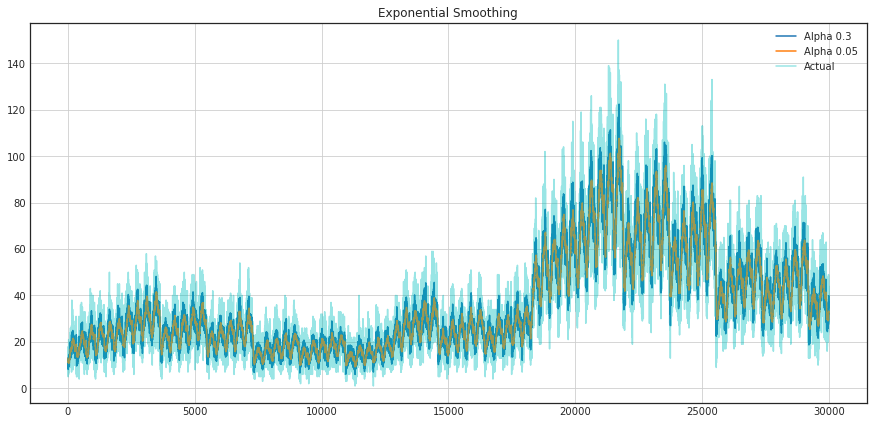

In [17]:
plotExponentialSmoothing(date_sales.sales[:30000], [0.3, 0.05])

## Double exponential Smoothing

Up to now, the methods that we've have seen are for a single future point prediction (with some nice smoothing). That is cool, but it is also not enough. Let's extend exponential smoothing so that we can predict two future points (of course, we will also include more smoothing).

Series decomposition will help us -- we obtain two components: intercept (i.e. level) $\ell$ and slope (i.e. trend) $b$. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

- The first one describes the intercept, which, as before, depends on the current value of the series.
- The second term is now split into previous values of the level and of the trend. 
    -  The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the $\beta$ coefficient is a weight for exponential smoothing. 
- The final prediction is the sum of the model values of the intercept and trend.

In [18]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.pyplot.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.pyplot.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.pyplot.plot(series.values, label = "Actual", alpha = 0.1)
        plt.pyplot.legend(loc="best")
        plt.pyplot.axis('tight')
        plt.pyplot.title("Double Exponential Smoothing")
        plt.pyplot.grid(True)

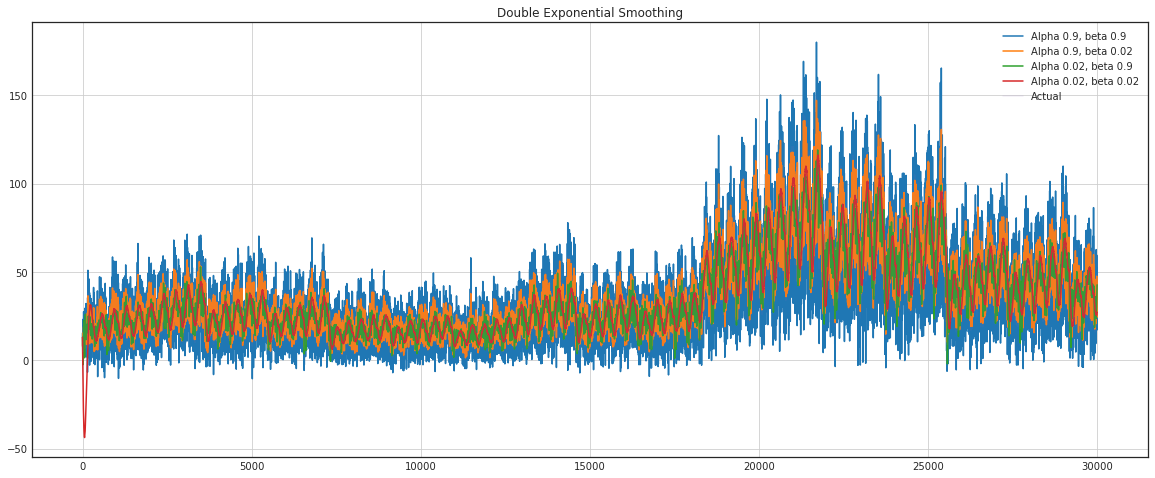

In [19]:
plotDoubleExponentialSmoothing(date_sales.sales[:30000], alphas=[0.9, 0.02], betas=[0.9, 0.02])

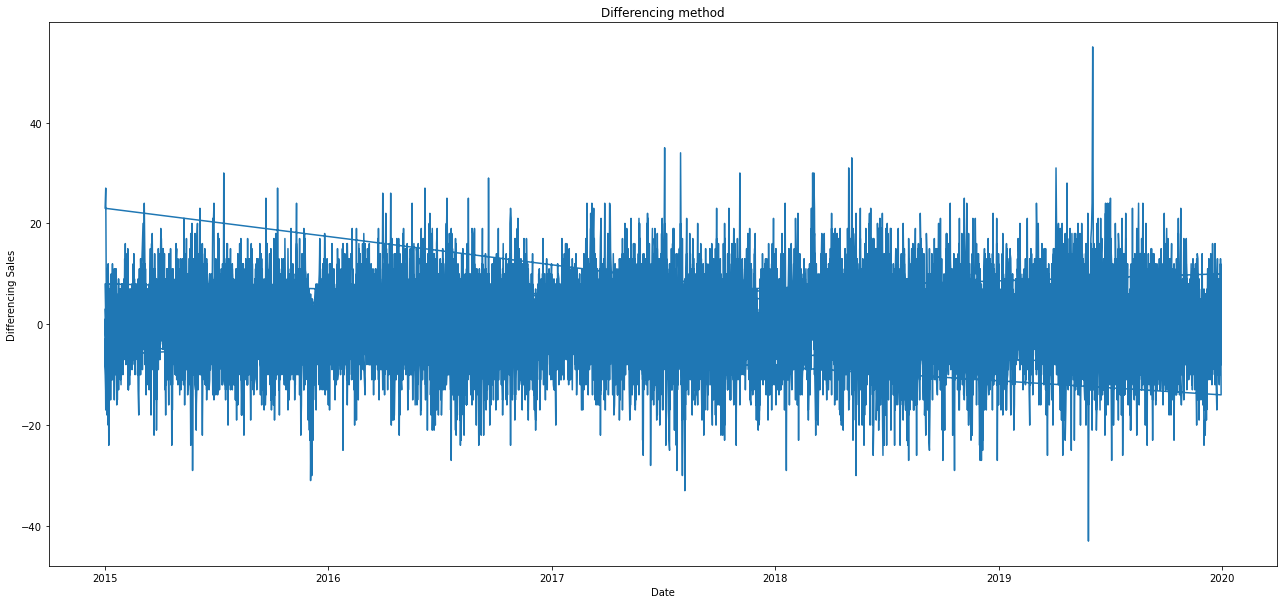

In [20]:
ts_diff = date_sales - date_sales.shift(7)
plt.pyplot.figure(figsize=(22,10))
plt.pyplot.plot(ts_diff[:20000])
plt.pyplot.title("Differencing method") 
plt.pyplot.xlabel("Date")
plt.pyplot.ylabel("Differencing Sales");

In [21]:
df_raw = df_raw.reset_index()

In [22]:
import re
def add_datepart(df, fldname, drop=True):

    """
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    """
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','weekofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if drop: 
        df.drop(fldname, axis=1, inplace=True)

add_datepart(df_raw,'date',False)

C:\Users\reddy\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:27: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



##  Few Pivoted Plots

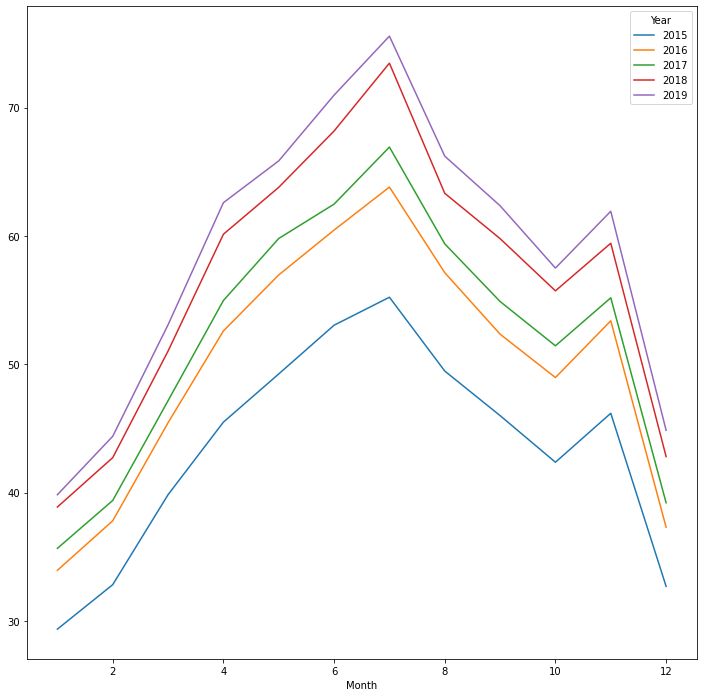

In [23]:
pivoted = pd.pivot_table(df_raw, values='sales', columns='Year', index='Month')
pivoted.plot(figsize=(12,12));

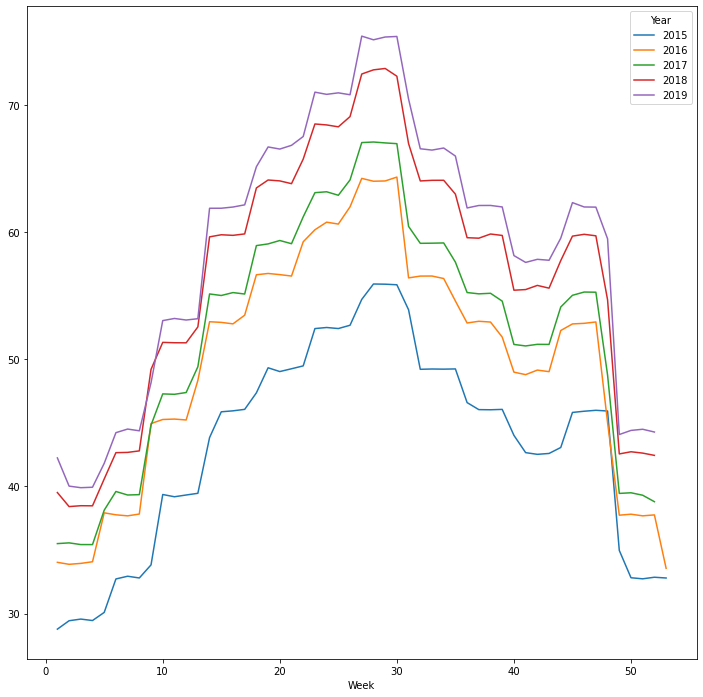

In [24]:
pivoted = pd.pivot_table(df_raw, values='sales' , columns='Year', index='Week')
pivoted.plot(figsize=(12,12));

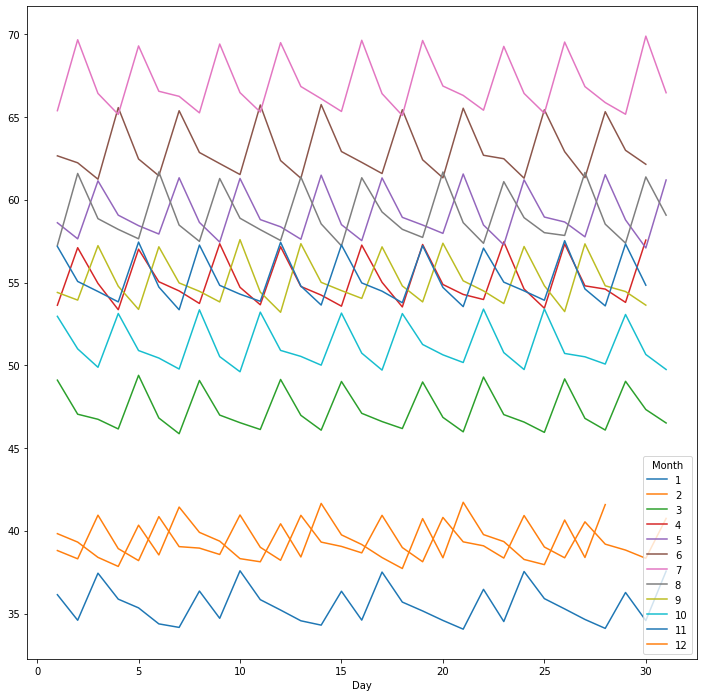

In [25]:
pivoted = pd.pivot_table(df_raw, values='sales' , columns='Month', index='Day')
pivoted.plot(figsize=(12,12));

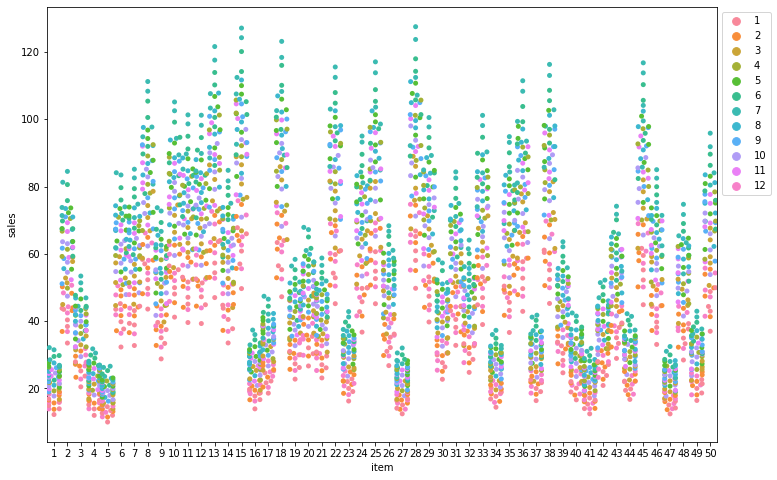

In [26]:
temp_1 = df_raw.groupby(['Year','Month','item'])['sales'].mean().reset_index()
plt.pyplot.figure(figsize=(12,8))
sns.swarmplot('item', 'sales', data=temp_1, hue = 'Month');
# Place legend to the right
plt.pyplot.legend(bbox_to_anchor=(1, 1), loc=2);

<Figure size 864x576 with 0 Axes>

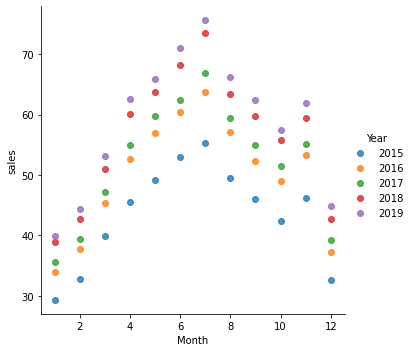

In [27]:
temp_1 = df_raw.groupby(['Year','Month'])['sales'].mean().reset_index()
plt.pyplot.figure(figsize=(12,8));
sns.lmplot('Month','sales',data = temp_1, hue='Year', fit_reg= False);

C:\Users\reddy\anaconda3\envs\v-env\lib\site-packages\seaborn\categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



<Figure size 864x576 with 0 Axes>

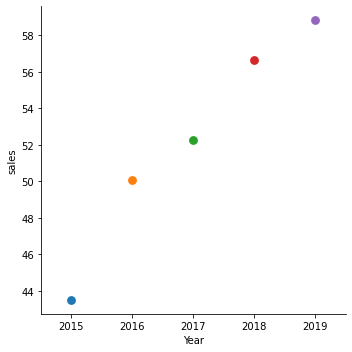

In [28]:
temp_1 = df_raw.groupby(['Year'])['sales'].mean().reset_index()
plt.pyplot.figure(figsize=(12,8));
sns.factorplot('Year','sales',data = temp_1, hue='Year', kind='point');

## Prophet

Let's take a closer look at how Prophet works. In its essence, this library utilizes the additive regression model $y(t)$ comprising the following components:

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t},$$ where:

- Trend $g(t)$ models non-periodic changes.
- Seasonality $s(t)$ represents periodic changes.
- Holidays component $h(t)$ contributes information about holidays and events.


>Trend

 A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend as “changing direction”, when it might go from an increasing trend to a decreasing trend.
 
> Seasonal

 A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known frequency.

> Cycle

A cycle occurs when the data exhibit rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”. The duration of these fluctuations is usually at least 2 years.

In [70]:
df = date_sales.reset_index()
df.columns = ['ds', 'y']

In [71]:
df_raw.head()

,date,dept,item,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,weekofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,2015-01-01,1,1,13.0,2015,1,1,1,3,1,1,False,True,False,True,False,True
1,2015-01-02,1,1,11.0,2015,1,1,2,4,2,1,False,False,False,False,False,False
2,2015-01-03,1,1,14.0,2015,1,1,3,5,3,1,False,False,False,False,False,False
3,2015-01-04,1,1,13.0,2015,1,1,4,6,4,1,False,False,False,False,False,False
4,2015-01-05,1,1,10.0,2015,1,2,5,0,5,2,False,False,False,False,False,False


In [72]:
df['dept'] = df_raw['dept'].copy()
df['Week'] = df_raw['Week'].copy()
df['item'] = df_raw['item'].copy()

In [73]:
df.to_csv('ProphetData.csv',index=False)

In [74]:
df = df[(df['item'] == 20) & (df['dept'] == 1)]

In [75]:
df.groupby(['Week','dept','item'])['y'].mean().reset_index().head(10)

,Week,dept,item,y
0,1,1,20,29.235294
1,2,1,20,29.085714
2,3,1,20,28.800000
3,4,1,20,27.914286
4,5,1,20,30.342857
5,6,1,20,32.571429
6,7,1,20,31.571429
7,8,1,20,33.628571
8,9,1,20,37.647059
9,10,1,20,39.171429


- The authors of the library generally advise to make predictions based on at least several months, ideally, more than a year of historical data. Luckily, in our case we have more than a couple of years of data to fit the model.

- To measure the quality of our forecast, we need to split our dataset into the historical part and the prediction part... (We should have done this)

In [45]:
prediction_size = 30
train_df = df
train_df.tail(n=3)

,ds,y,dept,Week,item
1822,2019-12-29,65.0,1,52,15
1823,2019-12-30,77.0,1,1,15
1824,2019-12-31,64.0,1,1,15


Now we need to create a new Prophet object. Here we can pass the parameters of the model into the constructor. But currently we will use the defaults as it is.. Then we train our model by invoking its fit method on our training dataset:

In [46]:
%%time
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
m.fit(train_df[['ds','y']]);

Wall time: 9.24 s


Using the helper method ```Prophet.make_future_dataframe```, we create a dataframe which will contain all dates from the history and also extend into the future for those 92 days that we left out before.

In [47]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
1852,2020-01-28
1853,2020-01-29
1854,2020-01-30


We predict values with Prophet by passing in the dates for which we want to create a forecast. If we also supply the historical dates (as in our case), then in addition to the prediction we will get an in-sample fit for the history. Let's call the model's predict method with our future dataframe as an input:

In [48]:
%%time
forecast = m.predict(future)
forecast.head(3)

Wall time: 11.3 s


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,46.249412,16.153654,46.637453,46.249412,46.249412,-14.441496,-14.441496,-14.441496,17.03951,...,-10.368298,-10.368298,-10.368298,-21.112707,-21.112707,-21.112707,0.0,0.0,0.0,31.807916
1,2015-01-02,46.268213,20.715297,49.916858,46.268213,46.268213,-10.760352,-10.760352,-10.760352,17.03951,...,-6.729811,-6.729811,-6.729811,-21.070051,-21.070051,-21.070051,0.0,0.0,0.0,35.507861
2,2015-01-03,46.287014,25.415921,54.433290,46.287014,46.287014,-6.240951,-6.240951,-6.240951,17.03951,...,-2.213960,-2.213960,-2.213960,-21.066501,-21.066501,-21.066501,0.0,0.0,0.0,40.046063


In the resulting dataframe you can see many columns characterizing the prediction, including trend and seasonality components as well as their confidence intervals. The forecast itself is stored in the yhat column.

The Prophet library has its own built-in tools for visualization that enable us to quickly evaluate the result.

- First, there is a method called Prophet.plot that plots all the points from the forecast:
- The Second function Prophet.plot_components might be much more useful in our case. It allows us to observe different components of the model separately: trend, yearly and weekly seasonality. In addition, if you supply information about holidays and events to your model, they will also be shown in this plot.

Let's try it out:

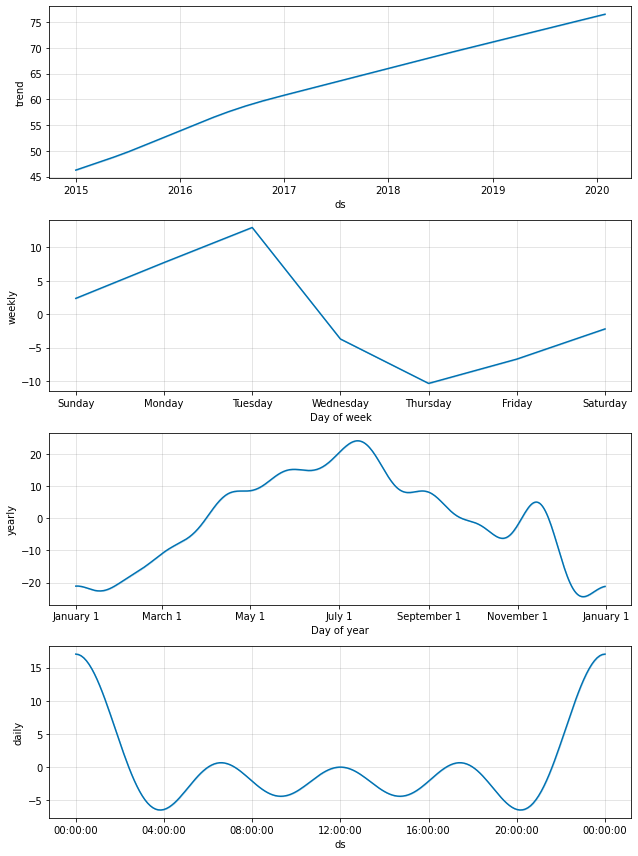

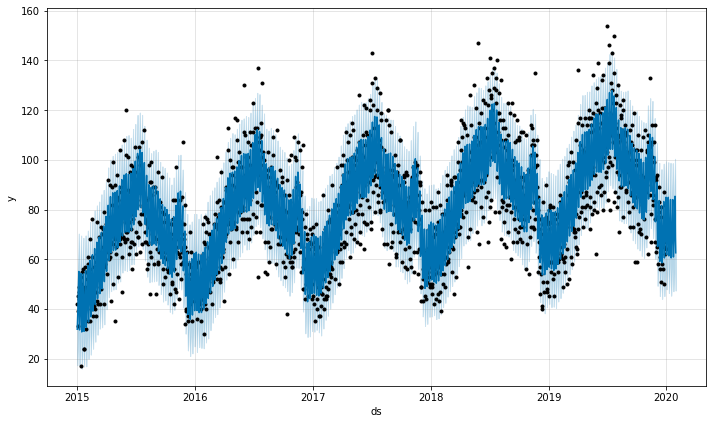

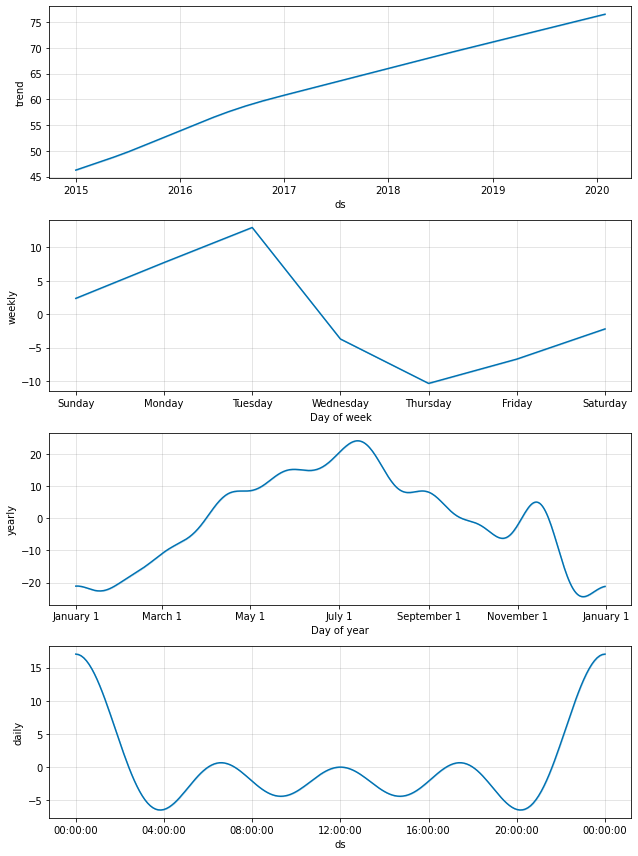

In [45]:
m.plot(forecast)
m.plot_components(forecast)

## Adding Holidays

In [68]:
playoffs = pd.DataFrame({
  'holiday' : 'playoff',
  'ds' : pd.to_datetime(['2013-01-12','2013-07-12','2013-12-24','2014-01-12', '2014-07-12', '2014-07-19',
                 '2014-07-02','2014-12-24', '2015-07-11','2015-12-24', '2016-07-17',
                 '2016-07-24', '2016-07-07','2016-07-24','2016-12-24','2017-07-17','2017-07-24','2017-07-07','2017-12-24']),
  'lower_window' : 0,
  'upper_window' : 2}
)
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2013-01-01','2013-01-21','2013-02-14','2013-02-18',
'2013-05-27','2013-07-04','2013-09-02','2013-10-14','2013-11-11','2013-11-28','2013-12-25','2014-01-01','2014-01-20','2014-02-14','2014-02-17',
'2014-05-26','2014-07-04','2014-09-01','2014-10-13','2014-11-11','2014-11-27','2014-12-25','2015-01-01','2015-01-19','2015-02-14','2015-02-16',
'2015-05-25','2015-07-03','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-12-25','2016-01-01','2016-01-18','2016-02-14','2016-02-15',
'2016-05-30','2016-07-04','2016-09-05','2016-10-10','2016-11-11','2016-11-24','2016-12-25','2017-01-02','2017-01-16','2017-02-14','2017-02-20',
'2017-05-29','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-12-25','2018-01-01','2018-01-15','2018-02-14','2018-02-19'
                       ]),
  'lower_window': 0,
  'upper_window': 3,
})

holidays = pd.concat((playoffs, superbowls))
holidays.to_csv('ProphetHolidays.csv', index=False)

In [47]:
%%time
m_holi = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, holidays=holidays)
m_holi.fit(train_df[['ds','y']]);

Wall time: 1.54 s


In [49]:
future_holi = m_holi.make_future_dataframe(periods=prediction_size)
future_holi.tail(n=3)

,ds
1852,2020-01-28
1853,2020-01-29
1854,2020-01-30


The holiday effect can be seen in the forecast dataframe:

In [50]:
%%time
forecast_holi = m_holi.predict(future_holi)
forecast_holi.tail(n=3)

Wall time: 3.35 s


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1852,2020-01-28,76.636403,70.536415,100.707557,76.632810,76.637736,8.648765,8.648765,8.648765,16.856041,...,12.962790,12.962790,12.962790,-21.170067,-21.170067,-21.170067,0.0,0.0,0.0,85.285168
1853,2020-01-29,76.649898,54.333679,83.873664,76.646023,76.651589,-7.775987,-7.775987,-7.775987,16.856041,...,-3.723307,-3.723307,-3.723307,-20.908721,-20.908721,-20.908721,0.0,0.0,0.0,68.873911
1854,2020-01-30,76.663393,47.626584,77.282648,76.658962,76.665203,-14.148872,-14.148872,-14.148872,16.856041,...,-10.368761,-10.368761,-10.368761,-20.636152,-20.636152,-20.636152,0.0,0.0,0.0,62.514522


The holiday effects will also show up in the components plot, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl:

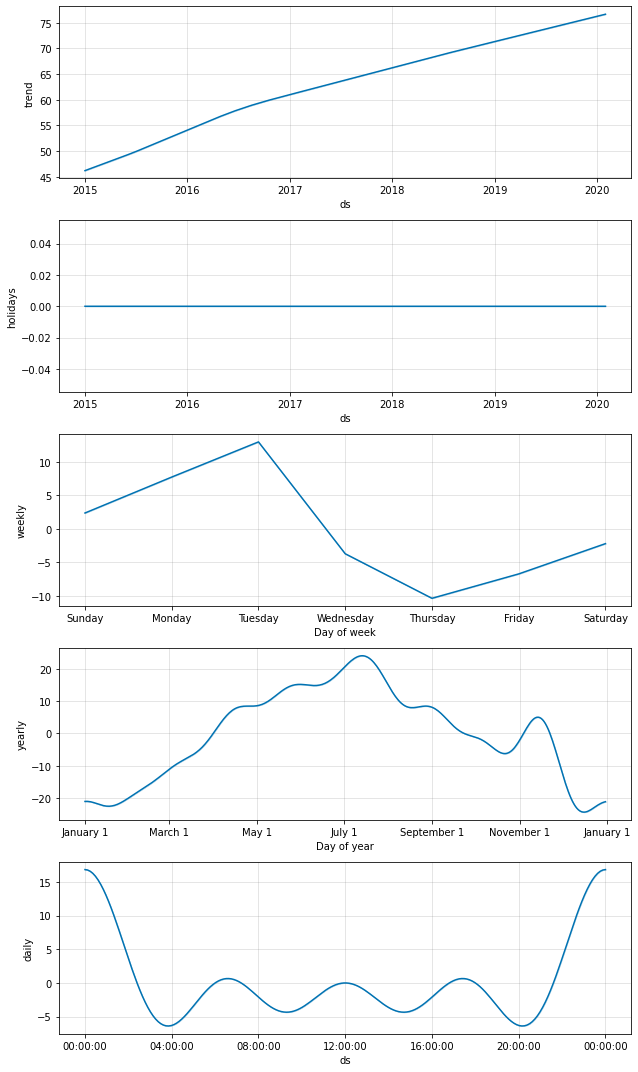

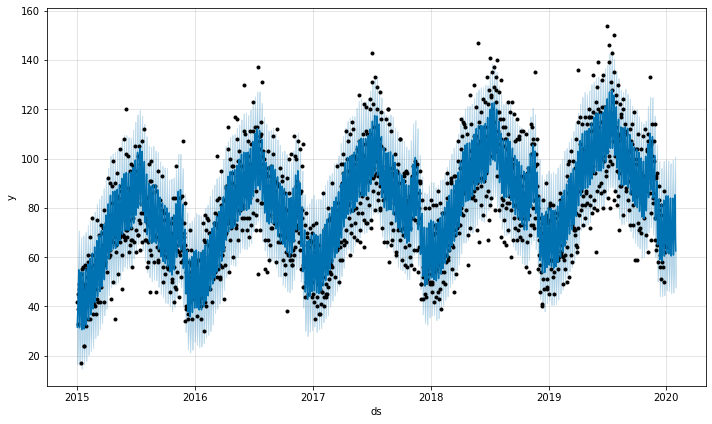

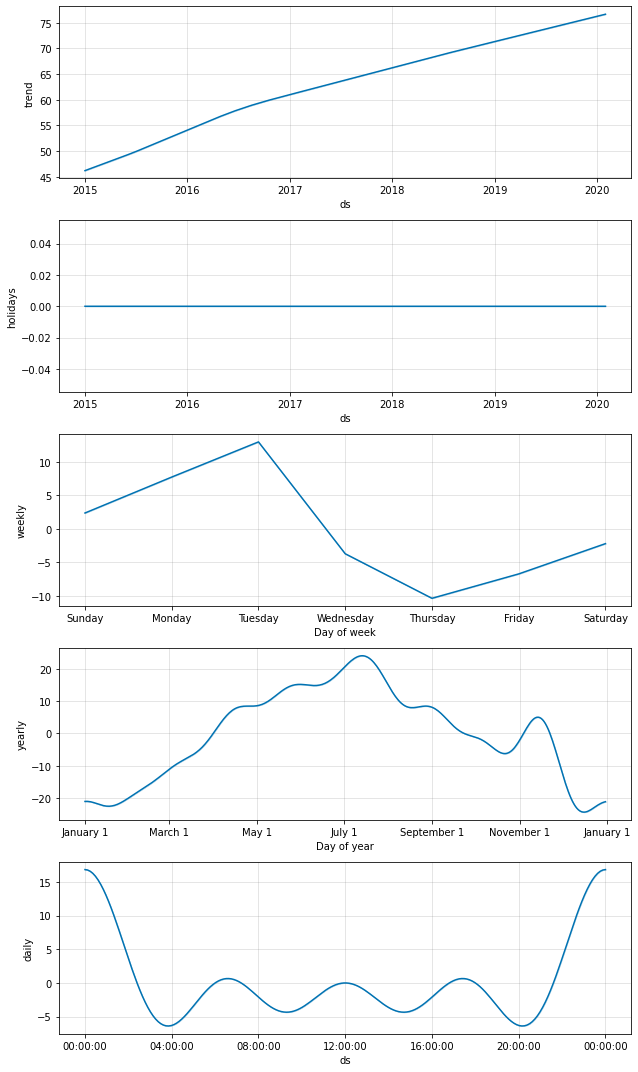

In [51]:
m_holi.plot(forecast_holi)
m_holi.plot_components(forecast_holi)